# Capstone Project: Create a Customer Segmentation Report for Arvato Financial Services

## Part 3: Kaggle Competition

In this notebook, I will create a model to predict individuals that are most likely to respond to a mailout campaign. The model will be tested in a competition on Kaggle.

Since there is a large imbalance in dataset, in which most people do not repond to the campaign, using accuracy to capture the performance of the model would not be very appropriate. Instead, the AUC which is the Area under the ROC curve will be used to evaluate how good the model is. The ROC curve plots the True Postive Rate against the False Positive Rate, which can be throught of as the proportion of correct predictions for the positive class against the proportion of errors for the negative class. The AUC provides a score between 0 and 1, and the closer the score is to 1, the better the model is.

### Import Libraries

In [2]:
# import libraries here; add more as necessary
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

from sklearn.impute import SimpleImputer
from sklearn.model_selection import cross_validate, RandomizedSearchCV, train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn import preprocessing

from xgboost import XGBRFClassifier, XGBClassifier
from lightgbm import LGBMClassifier


In [3]:
from helpers import optimize_df, check_df_columns, dropna_df, feat_engr, get_classification, plot_importance_features

### Cleaning data and Feature Engineering

In [4]:
# load in the data
train = pd.read_csv("Udacity_MAILOUT_052018_TRAIN.csv", sep=';')
test = pd.read_csv("Udacity_MAILOUT_052018_TEST.csv", sep=';')

/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (18,19) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [5]:
train.head()

,LNR,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTER_KIND1,ALTER_KIND2,ALTER_KIND3,ALTER_KIND4,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,ANZ_KINDER,ANZ_PERSONEN,ANZ_STATISTISCHE_HAUSHALTE,ANZ_TITEL,ARBEIT,BALLRAUM,CAMEO_DEU_2015,CAMEO_DEUG_2015,CAMEO_INTL_2015,CJT_GESAMTTYP,CJT_KATALOGNUTZER,CJT_TYP_1,CJT_TYP_2,CJT_TYP_3,CJT_TYP_4,CJT_TYP_5,CJT_TYP_6,D19_BANKEN_ANZ_12,D19_BANKEN_ANZ_24,D19_BANKEN_DATUM,D19_BANKEN_DIREKT,D19_BANKEN_GROSS,D19_BANKEN_LOKAL,D19_BANKEN_OFFLINE_DATUM,D19_BANKEN_ONLINE_DATUM,D19_BANKEN_ONLINE_QUOTE_12,D19_BANKEN_REST,D19_BEKLEIDUNG_GEH,D19_BEKLEIDUNG_REST,...,RELAT_AB,RETOURTYP_BK_S,RT_KEIN_ANREIZ,RT_SCHNAEPPCHEN,RT_UEBERGROESSE,SEMIO_DOM,SEMIO_ERL,SEMIO_FAM,SEMIO_KAEM,SEMIO_KRIT,SEMIO_KULT,SEMIO_LUST,SEMIO_MAT,SEMIO_PFLICHT,SEMIO_RAT,SEMIO_REL,SEMIO_SOZ,SEMIO_TRADV,SEMIO_VERT,SHOPPER_TYP,SOHO_KZ,STRUKTURTYP,TITEL_KZ,UMFELD_ALT,UMFELD_JUNG,UNGLEICHENN_FLAG,VERDICHTUNGSRAUM,VERS_TYP,VHA,VHN,VK_DHT4A,VK_DISTANZ,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,RESPONSE,ANREDE_KZ,ALTERSKATEGORIE_GROB
0,1763,2,1.0,8.0,NaN,NaN,NaN,NaN,8.0,15.0,0.0,0.0,1.0,13.0,0.0,3.0,5.0,5D,5,34,2.0,5.0,2.0,2.0,5.0,5.0,5.0,5.0,0,0,10,0,0,0,10,10,0.0,0,0,0,...,5.0,5.0,2.0,5.0,1.0,6,7,2,6,6,1,7,1,3,2,1,5,1,3,3,0.0,3.0,0.0,2.0,4.0,0.0,4.0,2,1.0,2.0,5.0,2.0,1.0,6.0,9.0,3.0,3,0,2,4
1,1771,1,4.0,13.0,NaN,NaN,NaN,NaN,13.0,1.0,0.0,0.0,2.0,1.0,0.0,2.0,5.0,5B,5,32,2.0,2.0,2.0,2.0,4.0,3.0,5.0,4.0,1,1,5,0,0,3,10,10,0.0,0,0,6,...,1.0,2.0,3.0,1.0,3.0,6,6,1,5,6,3,6,5,5,4,3,1,3,4,2,0.0,1.0,0.0,2.0,5.0,0.0,0.0,1,1.0,3.0,1.0,2.0,1.0,4.0,9.0,7.0,1,0,2,3
2,1776,1,1.0,9.0,NaN,NaN,NaN,NaN,7.0,0.0,NaN,0.0,0.0,1.0,0.0,4.0,1.0,2D,2,14,4.0,5.0,1.0,1.0,5.0,5.0,5.0,5.0,0,1,7,0,0,0,10,7,0.0,5,0,0,...,4.0,3.0,1.0,5.0,2.0,3,3,4,1,3,4,7,6,1,1,5,3,1,7,3,0.0,3.0,0.0,1.0,5.0,0.0,10.0,1,4.0,1.0,6.0,4.0,2.0,NaN,9.0,2.0,3,0,1,4
3,1460,2,1.0,6.0,NaN,NaN,NaN,NaN,6.0,4.0,0.0,0.0,2.0,4.0,0.0,4.0,2.0,2D,2,14,2.0,5.0,2.0,2.0,5.0,5.0,5.0,4.0,0,0,10,0,0,0,10,10,0.0,0,0,6,...,3.0,5.0,2.0,5.0,1.0,5,7,1,6,7,1,7,1,4,2,2,5,3,2,1,0.0,3.0,0.0,3.0,5.0,0.0,5.0,2,1.0,4.0,8.0,11.0,11.0,6.0,9.0,1.0,3,0,2,4
4,1783,2,1.0,9.0,NaN,NaN,NaN,NaN,9.0,53.0,0.0,0.0,1.0,44.0,0.0,3.0,4.0,7B,7,41,6.0,5.0,1.0,2.0,5.0,5.0,5.0,5.0,0,0,10,0,0,0,10,10,0.0,0,5,0,...,3.0,5.0,1.0,5.0,1.0,5,4,6,2,5,5,6,6,4,5,4,6,2,7,1,0.0,3.0,0.0,2.0,5.0,0.0,4.0,1,0.0,4.0,2.0,2.0,1.0,6.0,9.0,3.0,3,0,1,3


I will first check to see if the train and test set have the same columns. It seems that they have, with the test set having an extra 'RESPONSE' column which is the target value.

In [6]:
check_df_columns(train, test)

df1 has these extra columns:  {'RESPONSE'}
df2 has these extra columns:  set()


I will then clean the dataset and do some feature engineering with the train and test set as before.

In [7]:
train_clean, test_clean = dropna_df(train, test)

cleaning columns:  Index(['CAMEO_DEUG_2015', 'CAMEO_INTL_2015'], dtype='object')
cleaning column: CAMEO_DEU_2015
cleaning columns:  ['AGER_TYP', 'HEALTH_TYP', 'SHOPPER_TYP', 'VERS_TYP']
dropping columns:  ['ALTER_KIND1', 'ALTER_KIND2', 'ALTER_KIND3', 'ALTER_KIND4', 'KK_KUNDENTYP', 'KBA13_HERST_SONST']


In [8]:
train_clean = feat_engr(train_clean)
test_clean = feat_engr(test_clean)

Quick check to ensure that the train and test set still have the same columns.

In [9]:
check_df_columns(train_clean, test_clean)

df1 has these extra columns:  {'RESPONSE'}
df2 has these extra columns:  set()


I will now drop the extra 'RESPONSE' column in the train set

In [10]:
# drop the extra 'response' column
train_response = train_clean['RESPONSE']
train_clean = train_clean.drop(columns=['RESPONSE'])

Impute the missing values as in the previous notebook.

In [11]:
# impute NAs using mode
imputer = SimpleImputer(strategy='most_frequent')

# fit imputer on training data
imputer.fit(train_clean)

# fill in NAs in train and test set
train_imputed = imputer.transform(train_clean)
train_imputed = pd.DataFrame(train_imputed, columns=train_clean.columns)

test_imputed = imputer.transform(test_clean)
test_imputed = pd.DataFrame(test_imputed, columns=test_clean.columns)

Here, I have plotted the number of people who did and did not respond. As we can see, most of the individuals did not respond.

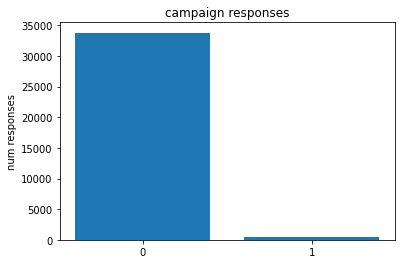

In [12]:
plt.bar(train_response.unique(), train_response.value_counts())
plt.xticks(np.arange(0, 2, step=1))
plt.title('campaign responses')
plt.ylabel('num responses')
plt.show()

I will drop the 'LNR' column as well as it represents the individual's ID and would not be useful for training.

In [13]:
# drop 'LNR' column as it should not be used for training
train_data = train_imputed.drop(columns=['LNR'])
test_data = test_imputed.drop(columns=['LNR'])

### Training the Model and Predicting

I will now train a simple decision tree classifier as a baseline model. A baseline model is a simple model and I will then try to train other models that achieves a better score than this baseline model. The decision tree is a common baseline model since it is easy to interpret and visualise.

As explained above, the AUC score will be used to evaluate the model. I will use a method called cross validation. The training set will be split into 3 smaller sets and the model is trained using 2 sets as training data, and the model is then evaluated with the remaining set. This is repeated 3 times, and scores will be calculated for each set, and the average can be obtained.

The decision tree classifier gives a score of around 0.757 on the training (and validation) data, and a lower score of 0.732 on the leaderboard.

In [24]:
# baseline model
# doing a simple decision tree classifier
dt = DecisionTreeClassifier(max_depth=5)

get_classification(dt, train_data, train_response, test_data, test_clean, 'sub_dt.csv')
# 0.732 on leaderboard

cv scores:  [0.73153126 0.78896593 0.75066196]
mean cv score:  0.7570530488337717


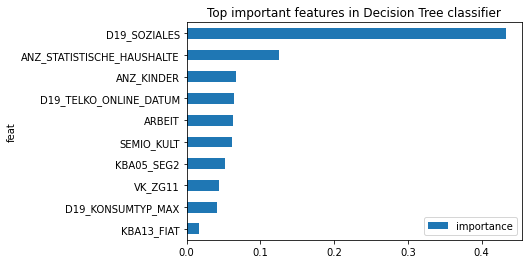

In [26]:
plot_importance_features(dt, train_data, "Decision Tree")

We can visualise the process in which the decision tree used to arrive at a decision

[Text(774.4301470588235, 996.6, 'D19_SOZIALES <= 1.5\ngini = 0.024\nsamples = 34214\nvalue = [33790, 424]'),
 Text(441.06617647058823, 815.4000000000001, 'D19_SOZIALES <= 0.5\ngini = 0.037\nsamples = 20173\nvalue = [19791, 382]'),
 Text(266.69117647058823, 634.2, 'ALTERSKATEGORIE_FEIN <= 23.0\ngini = 0.005\nsamples = 9023\nvalue = [8999, 24]'),
 Text(164.11764705882354, 453.0, 'D19_VERSAND_ANZ_12 <= 5.5\ngini = 0.005\nsamples = 9012\nvalue = [8989, 23]'),
 Text(82.05882352941177, 271.79999999999995, 'ANZ_HH_TITEL <= 2.5\ngini = 0.005\nsamples = 8989\nvalue = [8967, 22]'),
 Text(41.029411764705884, 90.59999999999991, 'gini = 0.005\nsamples = 8957\nvalue = [8936, 21]'),
 Text(123.08823529411765, 90.59999999999991, 'gini = 0.061\nsamples = 32\nvalue = [31, 1]'),
 Text(246.1764705882353, 271.79999999999995, 'D19_TELKO_ONLINE_DATUM <= 9.0\ngini = 0.083\nsamples = 23\nvalue = [22, 1]'),
 Text(205.14705882352942, 90.59999999999991, 'gini = 0.0\nsamples = 1\nvalue = [0, 1]'),
 Text(287.2058823

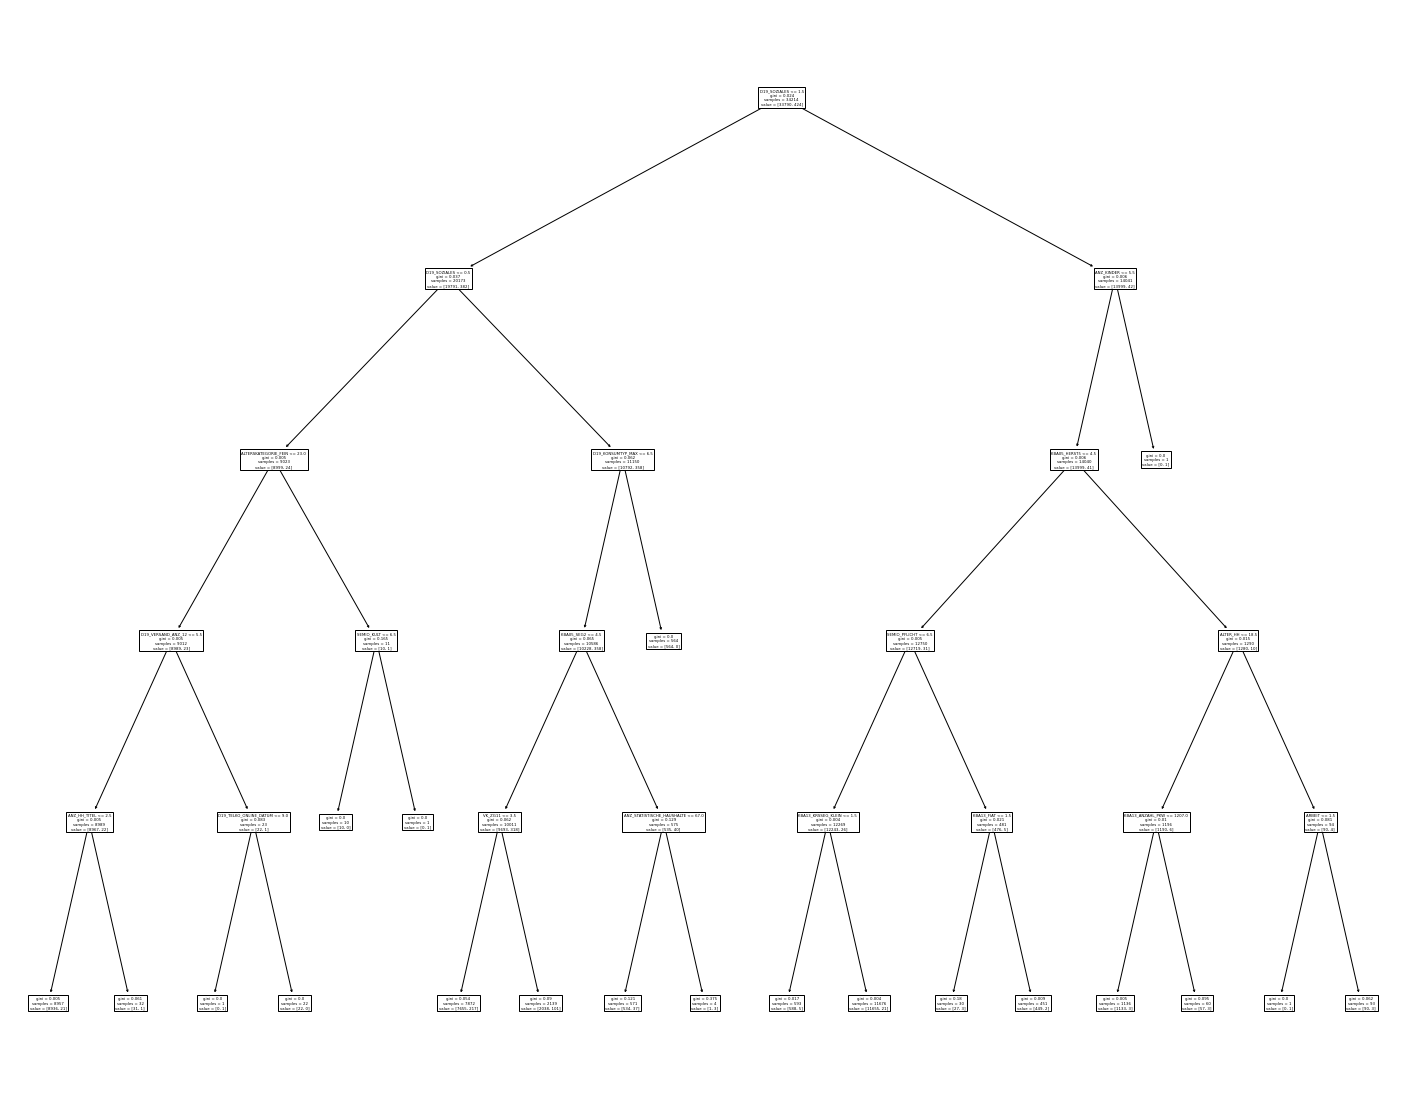

In [27]:
from sklearn import tree
fig = plt.figure(figsize=(25,20))
tree.plot_tree(dt,
               feature_names=train_data.columns)

I will now try with another simple model which is the Logistic Regression. 

Upon trying, it seems that the model failed to converge even after the total number of iterations have reahced the limit. This can be overcomed by increasing the number of iterations or scaling the data. Hence, I apply scaling of the data and increased the max iteration to 500.

The logistic regression model performs rather poorly during training (and validation), with a cv score of only 0.653. 

The logistic regression model might perform better if trained on fewer features, such as to use the important features identified in the previous section. However, since the cv score is much lower than the decision tree, I will move on try out other models.

In [52]:
train_data_scaled = preprocessing.scale(train_data)
test_data_scaled = preprocessing.scale(test_data)

lr = LogisticRegression(class_weight='balanced', max_iter=500)

get_classification(lr, train_data_scaled, train_response, test_data_scaled, test_clean, 'sub_lr.csv')
# 0.62

cv scores:  [0.63397795 0.65244231 0.67304228]
mean cv score:  0.6531541805145334


A random forest classifier is an ensemble method for classification. The forest is an ensemble of decision trees. Multiple decision trees give a class prediction and the class with most votes is chosen as the model's final prediction. Each tree in the random forest chooses from a subset of features when splitting their nodes, making the trees more varied. Moreover, each individual tree randomly samples N data from the dataset (of size N) with replacement in a process called bagging. Hence, the random forest ends up with trees trained on different dataset and features, making it more robust.

I first do some hyperparamter tuning for a random forest classifier. Using the best parameters, I then train the random forest model getting the cross validation score and use it for prediction on the test set.

The cv score on training is about 0.748 on training and slightly higher at 0.751 on the leaderboard. The random forest classifer performs better than a single decision tree.

In [ ]:
rf = RandomForestClassifier()

get_classification(rf, train_data, train_response, test_data, test_clean, 'sub_rf_untuned.csv')

# cv scores:  [0.60136542 0.59126668 0.62065805]
# mean cv score:  0.6044300520093353
# 0.616 on leaderboard

In [36]:
#tune rf
rf = RandomForestClassifier()
hyperparams = {'class_weight':['balanced', 'balanced_subsample', None],
               'criterion':['gini', 'entropy'],
               'max_depth':[None, 5, 10],
               'max_features':['auto', 'sqrt', 'log2'],
               'min_samples_leaf':[1, 2, 5],
               'n_estimators':[100, 250],
}

clf = RandomizedSearchCV(rf, hyperparams, scoring='roc_auc', n_iter=3)
clf.fit(train_data, train_response)
print(clf.best_params_)
print(clf.best_score_)

{'n_estimators': 250, 'min_samples_leaf': 5, 'max_features': 'sqrt', 'max_depth': 10, 'criterion': 'gini', 'class_weight': 'balanced'}
0.7478776352210017


In [39]:
rf = RandomForestClassifier(class_weight='balanced',
                            criterion='gini',
                            max_depth=10,
                            max_features='sqrt',
                            min_samples_leaf=5,
                            n_estimators=250
                            )

get_classification(rf, train_data, train_response, test_data, test_clean, 'sub_rf.csv')
# 0.751 on leaderboard

cv scores:  [0.73369059 0.7709495  0.75475274]
mean cv score:  0.7531309437020983


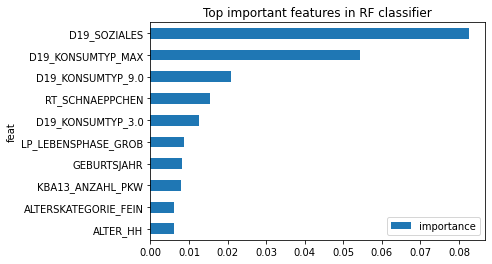

In [53]:
plot_importance_features(rf, train_data, "RF")

The next algorithm i will try is the XGBoost Classifier, short for Extreme Gradient Boosting Algorithm, which works by graident boosting decision trees. The term gradient boosting is used because the gradient descent algorithm is used to minimise loss when new models are added. Mistakes made by the previous models are learnt and this results in an improvement in performance in the model at the next step. This is repeated until there is no room for improvement.

The cv score of the xgb model is 0.783, which is much higher than previous models I have tried so far. Submitting it on the Kaggle competition gives a score 0.805 which looks quite good.

In [ ]:
xgb = XGBClassifier()

get_classification(xgb, train_data, train_response, test_data, test_clean, 'sub_xgb_untuned.csv')

# cv scores:  [0.76669601 0.78953772 0.77686872]
# mean cv score:  0.7777008154868993
# 0.791 on leaderboard

In [ ]:
# tune gbc
gbc = XGBClassifier(eval_metric='auc', objective='binary:logistic')
hyperparams = {'alpha': [0, 1e-9, 1e-4],
               'colsample_by_tree': [0.5, 0.7, 1],
               'gamma': [0, 0.5, 1],
               'learning_rate': [0.01, 0.014, 0.1, 0.4],
               'max_depth': [5, 6, 7],
               'n_estimators': [100, 235, 375],
               'subsample': [0.5, 0.7, 1]
}

clf = RandomizedSearchCV(gbc, hyperparams, scoring='roc_auc')
clf.fit(train_data, train_response)
print(clf.best_params_)
print(clf.best_score_)

In [54]:
xgb = XGBClassifier(alpha=1e-09,
                    colsample_bytree=0.7, 
                    eval_metric='auc',
                    objective='binary:logistic', 
                    gamma=1.0,
                    learning_rate=0.014, 
                    max_depth=7,
                    n_estimators=235, 
                    subsample=0.5)

get_classification(xgb, train_data, train_response, test_data, test_clean, 'sub_xgb.csv')
#0.805

cv scores:  [0.76343293 0.79854703 0.78568878]
mean cv score:  0.7825562477414097


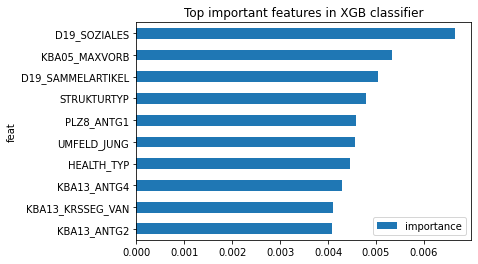

In [55]:
plot_importance_features(xgb, train_data, "XGB")

The final model I will try is Light GBM. Rather than spliting the tree depth-wise, Light GBM splits the tree leaf-wise. This leaf-wise algorithm can reduce more loss than depth-wise, hence improving the performance of the model. The term 'light' stems from the fact that it is fast.

I will first tune the hyperparameters for the light GBM model and then use the best parameters for prediction. This model gives a cv score of about 0.774 during training and a similar score of 0.778 on the leaderboard.

In [ ]:
lgb = LGBMClassifier()

get_classification(lgb, train_data, train_response, test_data, test_clean, 'sub_lgb_untuned.csv')

# cv scores:  [0.75917629 0.75967427 0.76329953]
# mean cv score:  0.7607166932030337
# 0.753 on leaderboard

In [29]:
# tune lgbm
lgbm = LGBMClassifier(metric='auc', objective='binary')
hyperparams = {'learning_rate': [0.07, 0.1],
               'max_depth': [-1, 5, 10], 
               'reg_alpha': [0, 1e-5, 0.01, 1],
               'reg_lambda': [0, 1e-5, 0.01, 1],
               'scale_pos_weight': [1, 10],
               'sumbsample':[0.5, 0.8, 1]
}

clf = RandomizedSearchCV(lgbm, hyperparams, scoring='roc_auc')
clf.fit(train_data, train_response)
print(clf.best_params_)
print(clf.best_score_)

{'sumbsample': 0.8, 'scale_pos_weight': 1, 'reg_lambda': 0, 'reg_alpha': 1, 'max_depth': 10, 'learning_rate': 0.1}
0.7743036824081513


In [32]:
lgb = LGBMClassifier(objective='binary', 
                    metric='auc',
                    learning_rate=0.1, 
                    max_depth=10,
                    reg_alpha=1.0, 
                    reg_lambda=0,
                    scale_pos_weight=1, 
                    subsample=0.8)

get_classification(lgb, train_data, train_response, test_data, test_clean, 'sub_lgb.csv')
# 0.778 on leaderboard

cv scores:  [0.75953959 0.79485927 0.76823189]
mean cv score:  0.7742102490693337


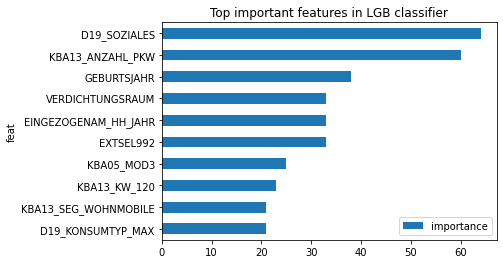

In [34]:
plot_importance_features(lgb, train_data, "LGB")